In [1]:
import gymnasium as gym
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import diffrax
from scipy.ndimage import zoom


import pde_opt
from pde_opt.numerics.domains import Domain
from pde_opt.rl_utils import detect_vortices
from pde_opt.numerics.equations.gross_pitaevskii import GPE2DTSControl
from pde_opt.numerics.solvers import StrangSplitting
from pde_opt.numerics.utils.initialization_utils import initialize_Psi

In [2]:
def density(psi):
    return jnp.abs(psi)**2

In [3]:
# Get variables with dimensions
atoms = 5e5
hbar = 1.05e-34 #J*s
omega = 2*jnp.pi*10 #1/s
omega_z = jnp.sqrt(8)*omega
epsilon = 0.0
mass = 3.8175406e-26 #kg (atomic mass of sodium-23)
a0 = 5.29177210903e-11
a_s = 100*a0
N = 256

x_s = jnp.sqrt(hbar/(mass*omega))
t_s = 1/omega

# Length of the x and y axes in meters
Lx = 150e-6 #meters
Ly = 150e-6 #meters

# Get dimensionless variables
Lx_ = Lx/x_s
Ly_ = Ly/x_s

# Get k
k = 4*jnp.pi*a_s*atoms*jnp.sqrt((mass*omega_z)/(2*jnp.pi*hbar))

epsilon = 0.0

t_start = 0.0
t_final = 0.05
dt = 1e-5

t_start_ = t_start/t_s
t_final_ = t_final/t_s
dt_ = dt/t_s

domain_ = Domain((N,N,), ((-Lx_/2, Lx_/2), (-Ly_/2, Ly_/2),), "dimensionless")

In [4]:
Psi0 = initialize_Psi(N, width=100, vortexnumber=0)
Psi0_ = Psi0*x_s
Psi0_ /= jnp.sqrt(jnp.sum(density(Psi0_))*domain_.dx[0]**2)

In [5]:
eq = GPE2DTSControl(domain_, k, epsilon, lambda a,b,c: 0.0, trap_factor=1.0)

solver = StrangSplitting(eq.A_term, eq.domain.dx[0], eq.fft, eq.ifft, -1j)

In [6]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.B_terms(y, t))),
    solver,
    t0=t_start_,
    t1=t_final_,
    dt0=dt_,
    y0=jnp.stack([Psi0_.real, Psi0_.imag], axis=-1),
    saveat=diffrax.SaveAt(ts=jnp.linspace(t_start_, t_final_, 100)),
    max_steps=1000000,
)

ground_state = solution.ys[-1]

In [53]:
step_dt = 0.01/t_s
end_time = 1.0/t_s

In [54]:
def state_to_observation(state):
    _density = density(state[...,0] + 1j*state[...,1])
    return (np.clip(np.array(_density), 0, 0.01) * 100 * 255).astype(np.uint8)[None]

In [55]:
# reset function
def reset_function(domain):
    if ground_state.shape[:-1] != domain.points:
        # Reshape ground_state to match domain points
        zoom_factors = (domain.points[0] / ground_state.shape[0], 
                       domain.points[1] / ground_state.shape[1])
        resized = zoom(ground_state, zoom_factors, order=1)
        return resized
    return ground_state

In [56]:
# reward function
def reward_function(state):
    psi = state[...,0] + 1j*state[...,1]
    vorts = detect_vortices(psi, amp_thresh=0.00005, tol=0.5)
    return vorts["num_vortices"]

In [57]:
def update_control_parameter(old_control_value, new_control_value):
    path_fn = lambda t: (
        old_control_value[0] + (new_control_value[0] - old_control_value[0]) * t / step_dt,
        old_control_value[1] + (new_control_value[1] - old_control_value[1]) * t / step_dt,
    )
    def light(t, xs, ys):
        A = 30.0
        sigma = 2e-6 / x_s
        xi, yi = path_fn(t)
        return A*jnp.exp(-((xs-xi)**2 + (ys-yi)**2)/(2.0*sigma**2))
    return light

In [58]:
action_space_config = {
    "type": "continuous",
    "shape": (2,),
    "low": float(-1e-5 / x_s),
    "high": float(1e-5 / x_s),
}

static_equation_parameters = {
    "k": k,
    "e": epsilon,
    "trap_factor": 1.0,
}

solver_parameters = {
    "time_scale": (1.0 - 1j*0.01),
}

In [59]:
params = {
    "equation_type": GPE2DTSControl,
    "domain": domain_,
    "solver_type": StrangSplitting,
    "end_time": end_time,
    "step_dt": step_dt,
    "numeric_dt": dt_,
    "state_to_observation_func": state_to_observation,
    "reward_function": reward_function,
    "reset_func": reset_function,
    "reset_control_value": (0.0, 0.0),
    "update_control_value": lambda action, old_control_value: (old_control_value[0] + action[0], old_control_value[1] + action[1]),
    "update_control_parameter": update_control_parameter,
    "action_space_config": action_space_config,
    "static_equation_parameters": static_equation_parameters,
    "control_equation_parameter_name": "lights",
    "solver_parameters": solver_parameters
}

In [60]:
env = gym.make('PDEEnv-v0', **params)

In [61]:
print(f"Action space: {env.action_space}")  # Discrete(2) - left or right
print(f"Sample action: {env.action_space.sample()}")  # 0 or 1

# Box observation space (continuous values)
print(f"Observation space: {env.observation_space}")  # Box with 4 values
# Box([-4.8, -inf, -0.418, -inf], [4.8, inf, 0.418, inf])

Action space: Box(-1.5114268, 1.5114268, (2,), float32)
Sample action: [0.5738032  0.34559232]
Observation space: Box(0, 255, (1, 256, 256), uint8)


In [62]:
# Reset environment to start a new episode
observation, info = env.reset()
# observation: what the agent can "see" - cart position, velocity, pole angle, etc.
# info: extra debugging information (usually not needed for basic learning)


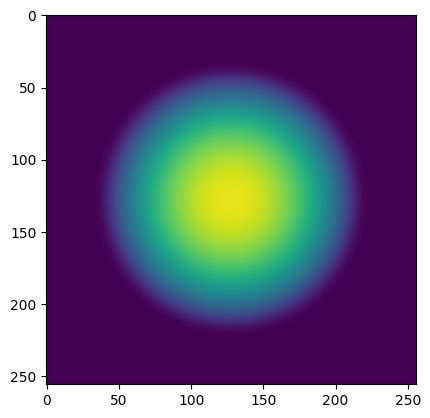

In [63]:
plt.imshow(observation[0], vmin=0, vmax=255)

In [64]:
action = env.action_space.sample()  # Random action for now - real agents will be smarter!

# Take the action and see what happens
observation, reward, terminated, truncated, info = env.step(action)
print(reward)

0


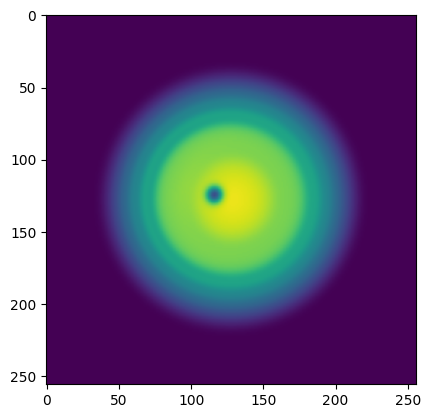

In [65]:
plt.imshow(observation[0], vmin=0, vmax=255)
plt.show()

In [66]:
observation, info = env.reset()

In [ ]:
episode_over = False
total_reward = 0

iters = 0

observations = []
while not episode_over:
    # Choose an action: 0 = push cart left, 1 = push cart right
    action = env.action_space.sample()  # Random action for now - real agents will be smarter!

    # Take the action and see what happens
    observation, reward, terminated, truncated, info = env.step(action)

    # reward: +1 for each step the pole stays upright
    # terminated: True if pole falls too far (agent failed)
    # truncated: True if we hit the time limit (500 steps)

    total_reward += reward
    episode_over = terminated or truncated
    iters += 1
    observations.append(observation[0])

print(f"Episode finished! Total reward: {total_reward}")
env.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Episode finished! Total reward: 331


In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(4,4))

ims = []
for i in range(0, len(observations), 2):
    im = ax.imshow(observations[i], animated=True, 
                   vmin=0.0, vmax=255,
                   extent=[domain_.box[0][0], domain_.box[0][1], 
                          domain_.box[1][0], domain_.box[1][1]])
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

plt.xlabel('x')
plt.ylabel('y')

plt.close()

HTML(ani.to_jshtml())